Attention Tensorflow Implementation

- Tensorflow.org "Neural machine translation with attention" 문서를 참고했습니다. <br> https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [7]:
# 분석에 필요한 사전 라이브러리를 다운받습니다.

!pip install einops
!pip install tensorflow-text

import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

사용 데이터셋: Ai-Hub 일상생활 및 구어체 한-영 번역 병렬 말뭉치 데이터 <br>
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=71265

In [20]:
# json 데이터셋을 가져옵니다.

import json

with open(r'./aihub-data.json', encoding='utf-8') as f:
    text = json.load(f)

In [21]:
# 데이터셋의 크기

print('한-영 대화 데이터셋 크기:', len(text['data']))

한-영 대화 데이터셋 크기: 1200307


In [22]:
# 예시

text['data'][100]

{'sn': 'ECOAR1A00922',
 'data_set': '일상생활및구어체',
 'domain': '해외고객과의채팅',
 'subdomain': '숙박,음식점',
 'en_original': 'We will send a notification message one day before your reservation.',
 'en': 'We will send a notification message one day before your reservation.',
 'mt': '예약 하루 전에 알림 메시지를 보내드립니다.',
 'ko': '예약 하루 전에 알림 메시지를 보내드려요.',
 'source_language': 'en',
 'target_language': 'ko',
 'word_count_ko': 6.0,
 'word_count_en': 11.0,
 'word_ratio': 0.545,
 'file_name': '해외고객과의채팅_숙박,음식점.xlsx',
 'source': '크라우드 소싱',
 'license': 'open',
 'style': '구어체',
 'included_unknown_words': False,
 'ner': None}

In [23]:
# 영어문장 정규화

from unidecode import unidecode
import re

def reg_eng(sentence):
    sentence = unidecode(sentence.lower().strip())
    
    sentence = re.sub(r"([,.?!'])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣,.?!]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [24]:
# 한국어 문장 정규화

def reg_kor(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([,.?!])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[|ㄱ-ㅎ|ㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [25]:
# json 파일 'en' 문장데이터 정규식 적용 후 array에 할당

tgt_raw = np.array([reg_eng(text['data'][_]['en']) for _ in range(len(text['data']))])

In [26]:
# 목표 (tgt) 문장 예시

tgt_raw[100:105]

array(['we will send a notification message one day before your reservation .',
       'thank you very much , see you this saturday .',
       'good morning , and thank you for calling us today .',
       'have you went to the garden ?',
       'such a pity , the garden is so beautiful .'], dtype='<U387')

In [27]:
# json 파일 'ko' 문장데이터 정규식 적용 후 array에 할당

src_raw = np.array([reg_kor(text['data'][_]['ko']) for _ in range(len(text['data']))])

In [28]:
# 기존 (src) 문장 예시

src_raw[100:105]

array(['예약 하루 전에 알림 메시지를 보내드려요 .', '감사합니다 , 이번 주 토요일에 뵙겠습니다 .',
       '좋은 아침이에요 , 오늘 전화해 주셔서 감사합니다 .', '정원에도 가셨나요 ?',
       '아쉽네요 , 정원이 정말 아름답거든요 .'], dtype='<U208')

In [29]:
# Train 데이터셋과 Validation 데이터셋을 나눕니다.
# rnd_train 변수로 train : validation = 8:2 비율로 랜덤하게 데이터를 나누고,
# 64 사이즈의 배치데이터로 나눕니다.

buffer_size = len(src_raw); batch_size = 64;

rnd_train = np.random.uniform(size = (len(tgt_raw), )) < 0.8

train_raw = (tf.data.Dataset
             .from_tensor_slices((src_raw[rnd_train], tgt_raw[rnd_train]))
             .shuffle(buffer_size)
             .batch(batch_size))

validation_raw = (tf.data.Dataset
             .from_tensor_slices((src_raw[~rnd_train], tgt_raw[~rnd_train]))
             .shuffle(buffer_size)
             .batch(batch_size))

In [30]:
# 문장의 시작과 끝을 '[START]', 'END' 변수로 명시합니다.

def sos_eos_tokenize(sentence):
    sentence = tf.strings.join(['[START]', sentence, '[END]'], separator = ' ')
    return sentence

In [31]:
# src 문장을 단어 단위 형태소로 벡터화합니다.

max_vocab_size = 10000

src_text_processor = tf.keras.layers.TextVectorization(standardize = sos_eos_tokenize,
                                                      max_tokens = max_vocab_size,
                                                      ragged = True)
src_text_processor.adapt(train_raw.map(lambda src, tgt: src))

In [32]:
src_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', '수', '?', '있습니다', '이']

In [33]:
# tgt 문장을 단어 단위 형태소로 벡터화합니다.

tgt_text_processor = tf.keras.layers.TextVectorization(standardize = sos_eos_tokenize,
                                                       max_tokens = max_vocab_size,
                                                       ragged=True)

tgt_text_processor.adapt(train_raw.map(lambda src, tgt: tgt))
tgt_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'the', 'to', 'i', 'you']

In [34]:
# Train, Validation 데이터셋을 zero-padded 토큰으로 변화합니다.
# Attention 모델에 사용하기 위해 한 단어의 텀을 가진 tgt_in, tgt_out 변수를 분리하고,
# tgt_in 변수와 context_vector인 src 변수를 묶어줍니다.

def text_processor(src, tgt):
    src = src_text_processor(src).to_tensor()
    tgt = tgt_text_processor(tgt)
    tgt_in = tgt[:, :-1].to_tensor()
    tgt_out = tgt[:, 1:].to_tensor()
    
    return (src, tgt_in), tgt_out

train = train_raw.map(text_processor, tf.data.AUTOTUNE)
validation = validation_raw.map(text_processor, tf.data.AUTOTUNE)

In [35]:
# 토큰화 예시

for (ex_src_tok, ex_tgt_in), ex_tgt_out in train.take(1):
    print('vectorized source sentences')
    print(ex_src_tok[0, :10].numpy())
    print('-' * 20)
    print('vectorized target input sentences (with [START], without [END])')
    print(ex_tgt_in[0, :10].numpy())
    print('-' * 20)
    print('vectorized target output sentences (without [START], with [END])')
    print(ex_tgt_out[0, :10].numpy())

vectorized source sentences
[   2    1    1    1 1837    5    1  374   19    4]
--------------------
vectorized target input sentences (with [START], without [END])
[  2  16  41  36   7 779  97   1   5  11]
--------------------
vectorized target output sentences (without [START], with [END])
[ 16  41  36   7 779  97   1   5  11  13]


In [36]:
UNITS = 256

In [37]:
# 벡터의 크기를 조회해 분석 중간 오류가 발생 시 확인 가능하비낟.

class ShapeChecker():
    def __init__(self):
        self.shapes = {}
        
    def __call__(self, tensor, names, broadcast = False):
        if not tf.executing_eagerly():
            return
        
        parsed = einops.parse_shape(tensor, names)
        
        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)
            
            if (broadcast and new_dim == 1):
                continue
                
            if old_dim is None:
                self.shapes[name] = new_dim
                continue
                
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                f"    found: {new_dim}\n"
                                f"    expected: {old_dim}\n")

In [38]:
# 인코더
# 인코더의 목적: 디코더가 문장에 나올 다음 단어를 예측할 때 참고할 context_vector 만들기
# 1. 토큰화한 문장을 임베딩한다.
# 2. 임베딩화한 문장을 Bidirectional GRU layer으로 RNN 네트워크를 구축한다
# 3. attention class에 해당 context_vector를 넘겨준다.

class Encoder(tf.keras.layers.Layer):
    def __init__(self, txt_processor, units):
        super(Encoder, self).__init__()
        self.txt_processor = txt_processor
        self.vocab_size = txt_processor.vocabulary_size()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero = True)
        
        self.rnn = tf.keras.layers.Bidirectional(merge_mode = 'sum',
                                                layer = tf.keras.layers.GRU(units,
                                                                           return_sequences = True,
                                                                           recurrent_initializer = 'glorot_uniform'))
        
    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')
        
        # 문장을 임베딩화합니다.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')
        
        # GRU layer으로 임베딩화한 sequence를 처리합니다.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')
        
        # 새로운 embedding을 반환합니다.
        return x
    
    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf_newaxis]
        context = self.txt_processor(texts).to_tensor()
        context = self(context)
        
        return context

In [39]:
# 인코더 토큰, 벡터 크기

encoder = Encoder(src_text_processor, UNITS)
ex_context = encoder(ex_src_tok)

print(f'Context tokens, shape (batch, s): {ex_src_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)


In [40]:
# Attention layer은 Decoder가 예측할 때 Encoder의 정보를 확인할 수 있게 한다.
# Attention layer은 context_vector와 query_vector의 가중 평균 데이터를 Decoder에 넘겨줍니다.

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = units, num_heads = 1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        
    def call(self, x, context):
        shape_checker = ShapeChecker()
        
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')
        
        attn_output, attn_scores = self.mha(query = x,
                                           value = context,
                                           return_attention_scores = True)
        
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')
        
        attn_scores = tf.reduce_mean(attn_scores, axis = 1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [41]:
attention_layer = CrossAttention(UNITS)

embed = tf.keras.layers.Embedding(tgt_text_processor.vocabulary_size(),
                                 output_dim = UNITS, mask_zero = True)
ex_tgt_embed = embed(ex_tgt_in)

result = attention_layer(ex_tgt_embed, ex_context)

In [42]:
# Attention layer 벡터 크기

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tgt_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 20, 256)
Target sequence, shape (batch, t, units): (64, 26, 256)
Attention result, shape (batch, t, units): (64, 26, 256)
Attention weights, shape (batch, t, s):    (64, 26, 20)


In [44]:
# Decoder는 문장에서 다음에 나올 토큰을 예측합니다.
# 1. 예측 토큰 이전까지 나온 문장을 GRU layer으로 처리합니다.
# 2. 해당 정보를 query_vector으로 처리해 Attention layer에서 인코더의 결과값을 참고합니다.
# 3. 위 정보들을 토대로 다음에 나올 단어를 예측합니다.

class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, txt_processor, units):
        super(Decoder, self).__init__()
        self.txt_processor = txt_processor
        self.vocab_size = txt_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary = txt_processor.get_vocabulary(),
                                                      mask_token = '', oov_token = '[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary = txt_processor.get_vocabulary(),
                                                      mask_token = '', oov_token = '[UNK]', invert = True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')
        
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                  units, mask_zero = True)
        self.rnn = tf.keras.layers.GRU(units,
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
        self.attention = CrossAttention(units)
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [45]:
@Decoder.add_method
def call(self, context, x,
         state = None,
         return_state = False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    x, state = self.rnn(x, initial_state = state)
    shape_checker(x, 'batch t units')

    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [46]:
decoder = Decoder(tgt_text_processor, UNITS)
logits = decoder(ex_context, ex_tgt_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tgt_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 20, 256)
input target tokens shape: (batch, t) (64, 26)
logits shape shape: (batch, target_vocabulary_size) (64, 26, 10000)


In [47]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype = tf.bool)
    embedded = self.embedding(start_tokens)
    
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [48]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis = -1, separator = ' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    
    return result

In [49]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token,
                        state = state, return_state = True)
    
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis = -1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples = 1)
        
    done = done | (next_token == self.end_token)
    next_token = tf.where(done, tf.constant(0, dtype = tf.int64), next_token)
    
    return next_token, done, state

In [50]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for _ in range(10):
    next_token, done, state = decoder.get_next_token(ex_context,
                                                    next_token,
                                                    done, state, temperature = 1.0)
    tokens.append(next_token)
    
tokens = tf.concat(tokens, axis = -1)

result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'alternatively whisk minus penalties inquiries correction comfortably mistakes sole zones',
       b'tastier filming festival climb tints fight anything accurately accepted bucket',
       b'w fifteen situations classrooms unicorn needing gaps team ring organ'],
      dtype=object)

In [51]:
# Train할 번역기 모델을 구축합니다.

class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, units, src_text_processor, tgt_text_processor):
        super().__init__()
        
        encoder = Encoder(src_text_processor, units)
        decoder = Decoder(tgt_text_processor, units)
        
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)
        
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        
        return logits

In [68]:
# 모델의 크기를 확인합니다.

model = Translator(UNITS, src_text_processor, tgt_text_processor)

logits = model((ex_src_tok, ex_tgt_in))

print(f'Context tokens, shape: (batch, s, units) {ex_src_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tgt_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 26)
logits, shape: (batch, t, target_vocabulary_size) (64, 26, 10000)


In [69]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True,
                                                           reduction = 'none')
    loss = loss_fn(y_true, y_pred)
    
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [70]:
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis = -1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [71]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [74]:
# 모델을 학습합니다.

history = model.fit(
    train.repeat(), 
    epochs = 50,
    steps_per_epoch = 100,
    validation_data = validation,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience = 3)])

Epoch 1/50
100/100 [==============================] - 57s 452ms/step - loss: 5.9673 - masked_acc: 0.1390 - masked_loss: 5.9673 - val_loss: 5.1048 - val_masked_acc: 0.2348 - val_masked_loss: 5.1048
Epoch 2/50
100/100 [==============================] - 45s 455ms/step - loss: 4.7051 - masked_acc: 0.2708 - masked_loss: 4.7051 - val_loss: 4.5241 - val_masked_acc: 0.2929 - val_masked_loss: 4.5241
Epoch 3/50
100/100 [==============================] - 49s 489ms/step - loss: 4.3780 - masked_acc: 0.3017 - masked_loss: 4.3780 - val_loss: 4.2386 - val_masked_acc: 0.3185 - val_masked_loss: 4.2386
Epoch 4/50
100/100 [==============================] - 53s 527ms/step - loss: 4.1474 - masked_acc: 0.3269 - masked_loss: 4.1474 - val_loss: 4.0692 - val_masked_acc: 0.3403 - val_masked_loss: 4.0692
Epoch 5/50
100/100 [==============================] - 49s 493ms/step - loss: 3.9634 - masked_acc: 0.3478 - masked_loss: 3.9634 - val_loss: 3.9166 - val_masked_acc: 0.3572 - val_masked_loss: 3.9166
Epoch 6/50
100/

In [1]:
# 모델의 loss을 확인합니다.

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

NameError: name 'plt' is not defined

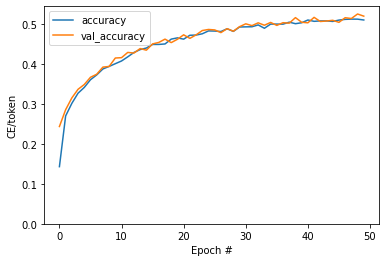

In [141]:
# 모델의 정확도를 확인합니다.

plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [75]:
# 새로운 문장을 입력했을 때, 토큰화 후 임베딩하여 알맞은 번역 문장을 출력합니다.

@Translator.add_method
def translate(self, texts, *, max_length = 50, temperature = 0.0):
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]
    
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)
    
    for _ in range(max_length):
        next_token, done, state = self.decoder.get_next_token(context, next_token,
                                                             done, state, temperature)
        
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
            
    tokens = tf.concat(tokens, axis = -1)
    self.last_attention_weights = tf.concat(attention_weights, axis = 1)
    
    result = self.decoder.tokens_to_text(tokens)
    
    return result

In [127]:
src_raw[101]

'감사합니다 , 이번 주 토요일에 뵙겠습니다 .'

In [ ]:
inp = str(input('문장을 입력하세요: '))
inp = reg_kor(inp)

result = model.translate([inp])
result[0].numpy().decode().strip()

문장을 입력하세요: 감사합니다, 오늘 하루.


In [76]:
# model이 학습한 weight을 저장합니다.

class Export(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(input_signature = [tf.TensorSpec(dtype = tf.string, shape = [None])])
    
    def translate(self, inputs):
        return self.model.translate(inputs)

In [77]:
export = Export(model)

In [78]:
tf.saved_model.save(export, 'kor-eng-translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: kor-eng-translator\assets


INFO:tensorflow:Assets written to: kor-eng-translator\assets
